# Reinforcement Learning - Student Project

### Implementation and Analysis of Twin Delayed Deep Deterministic Policy Gradient (TD3)

In [1]:
import gymnasium as gym
import numpy as np
import pickle
import pylab as plt
import TD3
import torch
import matplotlib.pyplot as plt
import laserhockey.hockey_env as h_env


from gymnasium import spaces
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm


# Constants

In [2]:
blue = '#264653'
green = '#2A9D8F'
olive= '#8AB17D'
yellow= '#E9C46A'
orange = '#F4A261'
red= '#E76F51'

colors = [blue, green, olive, yellow, orange, red]

## Helper Functions


In [3]:

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / float(N)    

def run(env, agent, n_episodes=100, noise=0):
    rewards = []
    observations = []
    actions = []
    for ep in range(1, n_episodes+1):
        ep_reward = 0
        state, _info = env.reset()
        for t in range(2000):
            action = agent.act(state, noise)
            state, reward, done, _trunc, _info = env.step(action)
            observations.append(state)
            actions.append(action)
            ep_reward += reward
            if done or _trunc:
                break
        rewards.append(ep_reward)
        ep_reward = 0
    print(f'Mean reward: {np.mean(rewards)}')
    observations = np.asarray(observations)
    actions = np.asarray(actions)
    return observations, actions, rewards

def create_subplot(left_plot_data, right_plot_data, left_plot_label, right_plot_label, left_plot_title, right_plot_title):
    fig, axs = plt.subplots(1, 2, figsize=(12, 4))

    if (isinstance(left_plot_data, list)):
        for data, label in zip(left_plot_data, left_plot_label):
            axs[0].plot(data, label=label)
    else: 
        axs[0].plot(left_plot_data, label=left_plot_label)
            
    axs[0].legend()
    axs[0].set_title(left_plot_title)

    if (isinstance(right_plot_data, list)):
        for data, label in zip(right_plot_data, right_plot_label):
            axs[1].plot(data, label=label)      
    else: 
        axs[1].plot(right_plot_data, label=right_plot_label)
        
    axs[1].legend()
    axs[1].set_title(right_plot_title)

    plt.tight_layout()
    plt.show()

def load_rewards_and_losses(mode, env_name, eps, ts, lr, s, tau):
    with open(f"./results/{mode}/td3_{env_name}-eps{eps}-t{ts}-l{lr}-s{s}-tau{tau}-stat.pkl", 'rb') as f:
        data = pickle.load(f)
        rewards = np.asarray(data["rewards"])
        losses =  np.asarray(data["losses"])
        
        return rewards, losses

def load_rewards(mode, env_name, eps, ts, lr, s, tau):
    with open(f"./results/{mode}/td3_{env_name}-eps{eps}-t{ts}-l{lr}-s{s}-tau{tau}-stat.pkl", 'rb') as f:
        data = pickle.load(f)
        rewards = np.asarray(data["rewards"])
        
        return rewards

def load_losses(mode, env_name, eps, ts, lr, s, tau):
    with open(f"./results/{mode}/td3_{env_name}-eps{eps}-t{ts}-l{lr}-s{s}-tau{tau}-stat.pkl", 'rb') as f:
        data = pickle.load(f)
        losses =  np.asarray(data["losses"])
        
        return losses

def load_checkpoint(env_name, episodes, eps, ts, lr, seed, tau):
    env = gym.make(env_name, render_mode="human")
    
    checkpoint = f"./results/td3/td3_{env_name}_{episodes}-eps{eps}-t{ts}-l{lr}-s{seed}-tau{tau}.pth"
    
    agent  = TD3.TD3Agent(env.observation_space, env.action_space, env_name)
    agent.restore_state(torch.load(checkpoint))
    
    return env, agent

# Evaluation - Twin Delayed DDPG (TD3)

### Tau dependency - Polyak averaging

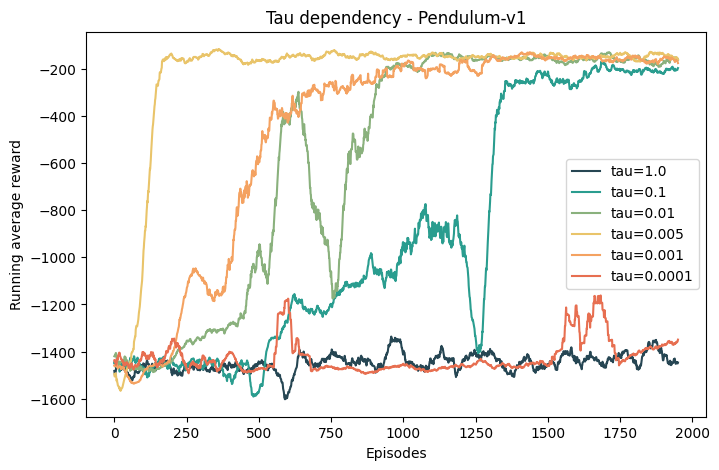

In [4]:
env_name = "Pendulum-v1"
rewards = {}
lr = 0.0001
eps=0.1
ts=32
seed=None
taus=[1.0, 0.1, 0.01, 0.005, 0.001, 0.0001 ]

for tau in taus:
    with open(f"./results/td3/td3_{env_name}-eps{eps}-t{ts}-l{lr}-s{seed}-tau{tau}-stat.pkl", 'rb') as f:
        data = pickle.load(f)
        rewards[tau] = data["rewards"]

fig=plt.figure(figsize=(8,5))
for i, (tau,rew) in enumerate(rewards.items()):
    color = colors[i]
    plt.plot(running_mean(rew,50),label=f"tau={tau}", color=color)
plt.legend()
plt.xlabel("Episodes")
plt.ylabel("Running average reward")
plt.title("Tau dependency - Pendulum-v1")
plt.savefig(f"./results/figures/tau_dependency_Pendulum-v1.jpg")
plt.show()

### Epsiolon dependency

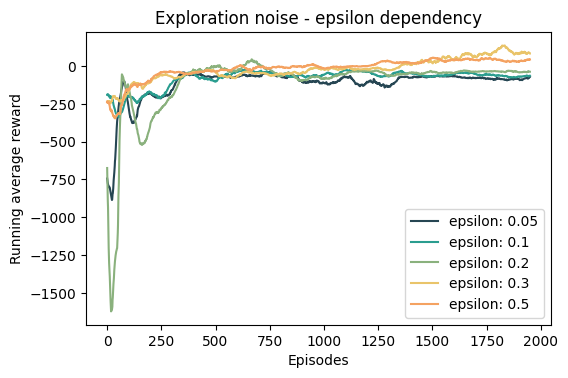

In [5]:
env_name='LunarLander-v2'
mode = 'td3'
eps=[0.05, 0.1, 0.2, 0.3, 0.5]
ts=32
lr=0.0001
seed=100
tau=0.005

rewards = []
for e in eps: 
    r = load_rewards(mode, env_name, e, ts, lr, seed, tau) 
    rewards.append(r)

fig=plt.figure(figsize=(6,3.8))
for i, (e,rew) in enumerate(zip(eps, rewards)):
    color = colors[i]
    plt.plot(running_mean(rew,50),label=f"epsilon: {e}", color=color)
plt.legend()
plt.xlabel("Episodes")
plt.ylabel("Running average reward")
plt.title("Exploration noise - epsilon dependency")

plt.savefig(f"./results/figures/epsilon_dependency_LunarLander.jpg")
plt.show()

##### Closer analysis for the last 100 episodes

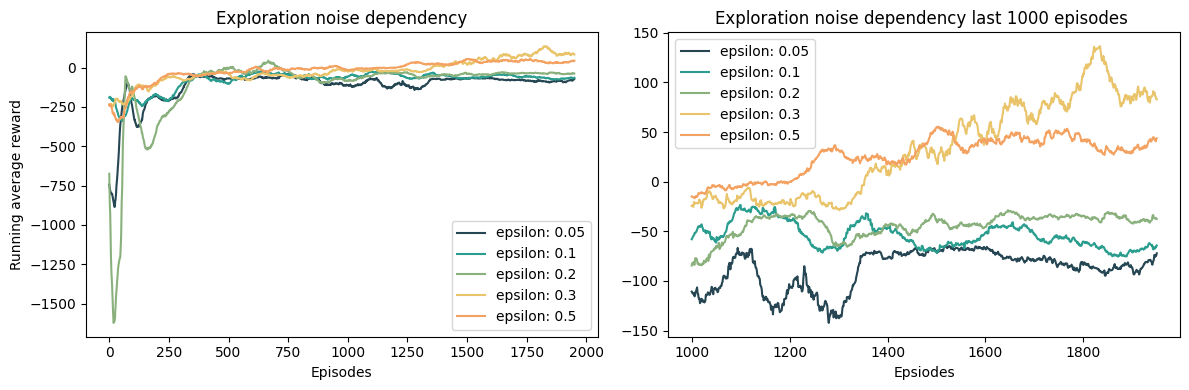

In [6]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))
x = np.arange(1000, 1951) # as the runnig mean is 50 we have 951 evaluations instead of 1000

for i, (e,rew) in enumerate(zip(eps, rewards)):
    color = colors[i]
    axs[0].plot(running_mean(rew,50),label=f"epsilon: {e}", color=color)
    axs[0].set_xlabel("Episodes")
    axs[0].set_ylabel("Running average reward")


axs[0].legend()
axs[0].set_title("Exploration noise dependency")

for i, (e,rew) in enumerate(zip(eps, rewards)):
    color = colors[i]
    axs[1].plot(x, running_mean(rew[-1000:],50),label=f"epsilon: {e}", color=color)
    axs[1].set_xlabel("Epsiodes")
    

axs[1].legend()
axs[1].set_title("Exploration noise dependency last 1000 episodes ")

plt.tight_layout()
plt.savefig(f"./results/figures/epsilon_dependency_LunarLander_subplot.jpg")
plt.show()

### Learning Rate dependency

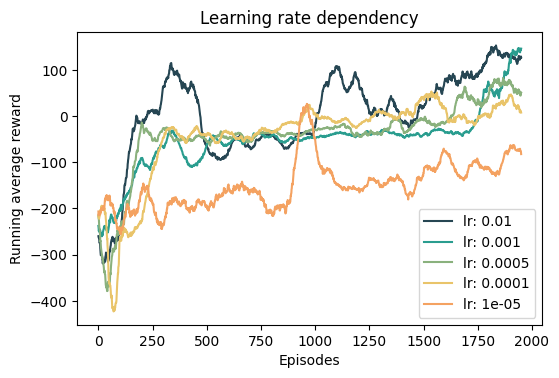

In [7]:
env_name='LunarLanderContinuous-v2'
mode = 'td3'
episodes=2000
eps = 0.3
ts=32
lrs=[0.01, 0.001, 0.0005, 0.0001, 0.00001]
seed=None
tau=0.005

rewards=[]
for lr in lrs: 
    r = load_rewards(mode, env_name, eps, ts, lr, seed, tau)
    rewards.append(r)

fig=plt.figure(figsize=(6,3.8))
for i, (lr,rew) in enumerate(zip(lrs, rewards)):
    color = colors[i]
    plt.plot(running_mean(rew,50),label=f"lr: {lr}", color=color)
plt.legend()
plt.xlabel("Episodes")
plt.ylabel("Running average reward")
plt.title("Learning rate dependency")

plt.savefig(f"./results/figures/learning_rate_dependency_LunarLander.jpg")
plt.show()

### Hockey Environment

In [8]:
# Constants for hockey environment
folder_name='hockey'
env_name='Hockey-v0'
episodes=6000
eps=0.1
ts=32
lr=0.001
seed=None
tau=0.005

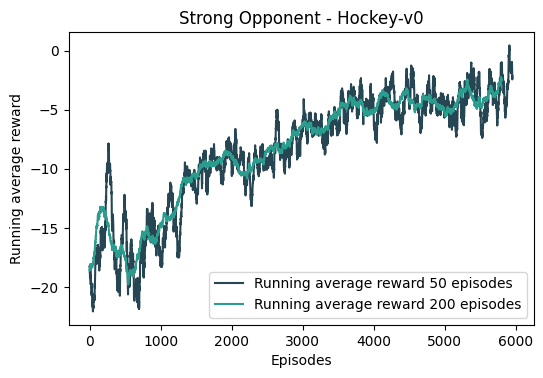

In [9]:

rewards = load_rewards(folder_name, env_name, eps, ts, lr, seed, tau)
fig=plt.figure(figsize=(6,3.8))
plt.plot(running_mean(rewards,50), color=colors[0], label="Running average reward 50 episodes")
plt.plot(running_mean(rewards,200), color=colors[1], label="Running average reward 200 episodes")
plt.legend()
plt.xlabel("Episodes")
plt.ylabel("Running average reward")
plt.title("Strong Opponent - Hockey-v0")

plt.savefig(f"./results/figures/hockey_strong_opponent_6000_eps01.jpg")
plt.show()

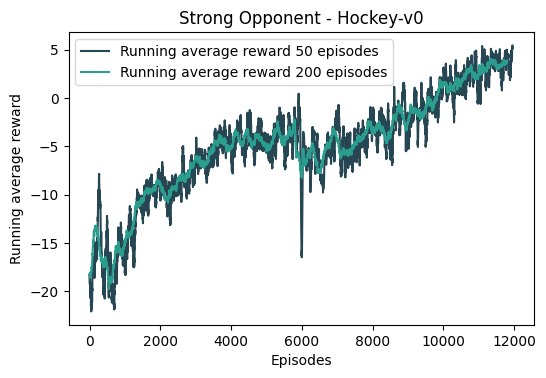

In [10]:
# After 6000 episodes the agent is still learning, so I let him play against a strong opponent for 6000 more episodes
episodes = 12000

with open(f"./results/hockey/td3_{env_name}_{episodes}-eps{eps}-t{ts}-l{lr}-s{seed}-tau{tau}-stat.pkl", 'rb') as f:
    data = pickle.load(f)
    further_rewards = np.asarray(data["rewards"])

total_rewards = np.concatenate((rewards, further_rewards))
fig=plt.figure(figsize=(6,3.8))

plt.plot(running_mean(total_rewards,50), color=colors[0], label="Running average reward 50 episodes")
plt.plot(running_mean(total_rewards,200), color=colors[1], label="Running average reward 200 episodes")
plt.legend()
plt.xlabel("Episodes")
plt.ylabel("Running average reward")
plt.title("Strong Opponent - Hockey-v0")
plt.savefig(f"./results/figures/hockey_strong_opponent_12000_eps01.jpg")
plt.show()

##### Continue training against strong opponent for 6000 furhter episodes with epsilon 0.3

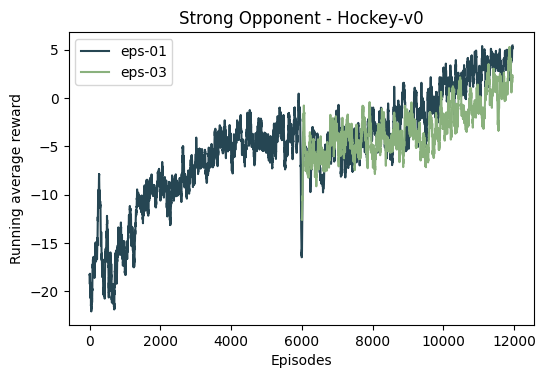

In [11]:
eps = 0.3
episodes = 12000

with open(f"./results/hockey/td3_{env_name}_{episodes}-eps{eps}-t{ts}-l{lr}-s{seed}-tau{tau}-stat.pkl", 'rb') as f:
    data = pickle.load(f)
    further_rewards_03 = np.asarray(data["rewards"])

x=np.arange(6000,11951)

fig=plt.figure(figsize=(6,3.8))
plt.plot(running_mean(total_rewards,50), color=colors[0], label="eps-01")
plt.plot(x,running_mean(further_rewards_03,50), color=colors[2], label="eps-03")
plt.legend()
plt.xlabel("Episodes")
plt.ylabel("Running average reward")
plt.title("Strong Opponent - Hockey-v0")
plt.savefig(f"./results/figures/hockey_strong_opponent_12000_eps01_and_03_from_6000_on.jpg")
plt.show()

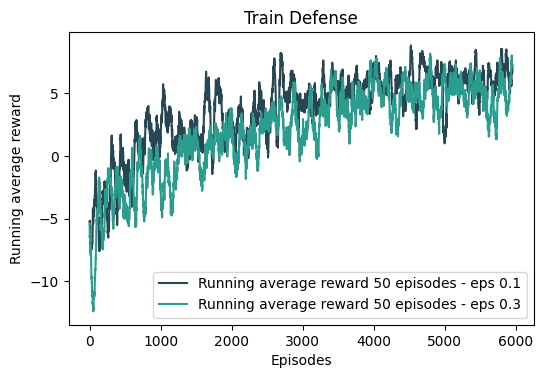

In [12]:
#### Train Defense
folder_name='hockey'

eps=0.3
seed=11
reward_defense_03 = load_rewards(folder_name, env_name, eps, ts, lr, seed, tau)

eps=0.1
seed=14
reward_defense_01 = load_rewards(folder_name, env_name, eps, ts, lr, seed, tau)


fig=plt.figure(figsize=(6,3.8))

plt.plot(running_mean(reward_defense_01,50), color=colors[0], label="Running average reward 50 episodes - eps 0.1")
plt.plot(running_mean(reward_defense_03,50), color=colors[1], label="Running average reward 50 episodes - eps 0.3")
plt.legend()
plt.xlabel("Episodes")
plt.ylabel("Running average reward")
plt.title("Train Defense")
plt.savefig(f"./results/figures/hockey_train_defense_eps_01_and_03.jpg")
plt.show()

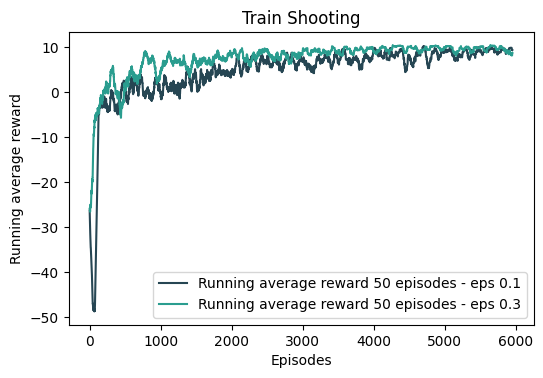

In [13]:
#### Train Shooting
folder_name='hockey'

eps=0.1
seed=15
reward_shooting_01 = load_rewards(folder_name, env_name, eps, ts, lr, seed, tau)

eps=0.3
seed=12
reward_shooting_03 = load_rewards(folder_name, env_name, eps, ts, lr, seed, tau)

fig=plt.figure(figsize=(6,3.8))

plt.plot(running_mean(reward_shooting_01,50), color=colors[0], label="Running average reward 50 episodes - eps 0.1")
plt.plot(running_mean(reward_shooting_03,50), color=colors[1], label="Running average reward 50 episodes - eps 0.3")

plt.legend()
plt.xlabel("Episodes")
plt.ylabel("Running average reward")
plt.title("Train Shooting")
plt.savefig(f"./results/figures/hockey_train_shooting_eps_01_and_03.jpg")
plt.show()

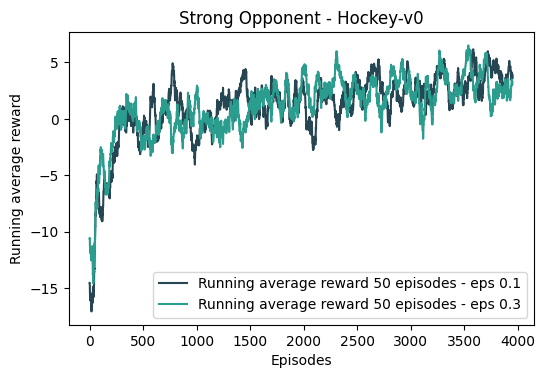

In [14]:
#### Train Normal

folder_name='hockey'

eps=0.1
seed=16
reward_normal_01 = load_rewards(folder_name, env_name, eps, ts, lr, seed, tau)

eps=0.3
seed=13
reward_normal_03 = load_rewards(folder_name, env_name, eps, ts, lr, seed, tau)

fig=plt.figure(figsize=(6,3.8))

plt.plot(running_mean(reward_normal_01,50), color=colors[0], label="Running average reward 50 episodes - eps 0.1")
plt.plot(running_mean(reward_normal_03[:4000],50), color=colors[1], label="Running average reward 50 episodes - eps 0.3")

plt.legend()
plt.xlabel("Episodes")
plt.ylabel("Running average reward")
plt.title("Strong Opponent - Hockey-v0")
plt.savefig(f"./results/figures/hockey_train_normal_eps_01_and_03.jpg")
plt.show()

#### Contribution of individual parts of TD3

In [15]:
eps = 0.1
seeds=[1001, 1002, 1003]
modes = ['only_clip', 'only_smooth', 'only_delay']

rewards=[]
for seed, mode in zip(seeds, modes):
    with open(f"./results/{mode}/td3_{env_name}-eps{eps}-t{ts}-l{lr}-s{seed}-tau{tau}-stat.pkl", 'rb') as f:
        data = pickle.load(f)
        rew = np.asarray(data["rewards"])
        rewards.append(rew)

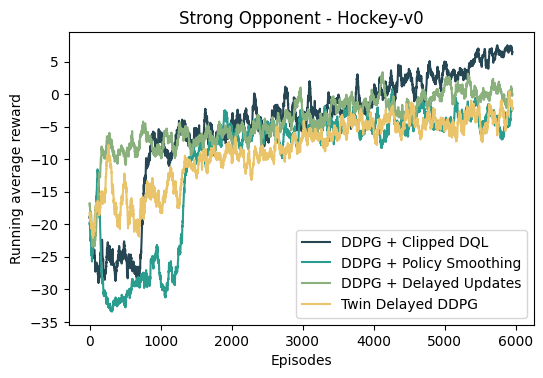

In [16]:
fig=plt.figure(figsize=(6,3.8))

plt.plot(running_mean(rewards[0],50), color=colors[0], label="DDPG + Clipped DQL")
plt.plot(running_mean(rewards[1],50), color=colors[1], label="DDPG + Policy Smoothing")
plt.plot(running_mean(rewards[2],50), color=colors[2], label="DDPG + Delayed Updates")
plt.plot(running_mean(total_rewards[:6000], 50), color=colors[3], label="Twin Delayed DDPG")

plt.legend()
plt.xlabel("Episodes")
plt.ylabel("Running average reward")
plt.title("Strong Opponent - Hockey-v0")
plt.savefig(f"./results/figures/hockey_contributions_individual_parts_TD3.jpg")
plt.show()

### Load checkpoint and check in human mode

In [27]:
env_name = "Hockey-v0"
env = h_env.HockeyEnv()

rewards = {}
episodes = 12000
seed=None
  
checkpoint = f"./models/network_parameters/td3_{env_name}_{episodes}-eps{eps}-t{ts}-l{lr}-s{seed}-tau{tau}.pth"    
agent  = TD3.TD3Agent(env.observation_space, env.action_space, env_name)
agent.restore_state(torch.load(checkpoint))


wins=[]
for i in range(50):
    env = h_env.HockeyEnv()
    obs, info = env.reset()
    obs_agent2 = env.obs_agent_two()
    player2 = h_env.BasicOpponent(weak=False)

    total_reward = 0
    for i in range(400):
        env.render(mode="human")
        a1 = agent.act(obs)
        a2 = player2.act(obs_agent2)
        obs, r, d, _, info = env.step(np.hstack([a1, a2]))
        if (info['winner'] != 0):
            wins.append(info['winner'])
        total_reward += r
        obs_agent2 = env.obs_agent_two()
        if d: break

env.close()